## Analyzing Weather Data from Open-Meteo API

Description: Open-Meteo is an open-source weather API and offers free access for non-commercial use.

### Summary

[The data](https://open-meteo.com/en/docs) will be accessed using the Open-Meteo, an open-source weather API.

| Column                                 | Description                                                                                                   |
|----------------------------------------|---------------------------------------------------------------------------------------------------------------|
| time                                   | The time of the weather observation.                                                                          |
| weathercode                            | The weather condition represented by a numeric code.                                                           |
| temperature_2m_max                     | The maximum air temperature at 2 meters above ground.                                                         |
| temperature_2m_min                     | The minimum air temperature at 2 meters above ground.                                                         |
| temperature_2m_mean                    | The mean air temperature at 2 meters above ground.                                                            |
| apparent_temperature_max               | The maximum apparent temperature, which is the perceived feels-like temperature combining wind chill factor, relative humidity, and solar radiation. |
| apparent_temperature_min               | The minimum apparent temperature.                                                                            |
| apparent_temperature_mean              | The mean apparent temperature.                                                                               |
| sunrise                                | The time of sunrise.                                                                                         |
| sunset                                 | The time of sunset.                                                                                          |
| precipitation_sum                      | The total precipitation (rain, showers, snow) sum.                                                            |
| rain_sum                               | The sum of only liquid precipitation (rain) of the preceding hour, including local showers and rain from large scale systems.                                             |
| snowfall_sum                           | The sum of snowfall amount of the preceding hour in centimeters. For the water equivalent in millimeters, divide by 7.                                                      |
| precipitation_hours                    | The number of hours of precipitation.                                                                        |
| windspeed_10m_max                      | The maximum wind speed at 10 meters above ground. Wind speed on 10 meters is the standard level.             |
| windgusts_10m_max                      | The maximum gusts at 10 meters above ground of the indicated hour. Wind gusts in CERRA are defined as the maximum wind gusts of the preceding hour. Please consult the ECMWF IFS documentation for more information on how wind gusts are parameterized in weather models. |
| winddirection_10m_dominant             | The dominant wind direction at 10 meters above ground.                                                        |
| shortwave_radiation_sum                | The sum of shortwave solar radiation as the average of the preceding hour. This is equal to the total global horizontal irradiation.                               |
| et0_fao_evapotranspiration             | ET₀ Reference Evapotranspiration of a well-watered grass field. Based on FAO-56 Penman-Monteith equations, ET₀ is calculated from temperature, wind speed, humidity, and solar radiation. Unlimited soil water is assumed. ET₀ is commonly used to estimate the required irrigation for plants. |

### Import Libraries

In [9]:
import requests
import pandas as pd
from pandas import json_normalize
import json
import plotly.express as px
from prophet import Prophet

### Fetching Weather Data from Open Meteo API

In [10]:
# Define the base URL
url = "https://archive-api.open-meteo.com/v1/archive"

# Define the query parameters as a dictionary
# Time interval: 2010-01-01 to 2023-07-21
# Location: İstanbul
querystring = {
    "latitude": "41.0138",
    "longitude": "28.9497",
    "start_date": "2010-01-01",
    "end_date": "2023-07-21",
    "daily": "weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration",
    "timezone": "auto"
}

# Send a GET request to the URL with the query parameters
response = requests.get(url, params=querystring)

# Print the JSON data returned by the API
# print(response.json())

In [11]:
# Extract the JSON content from the response
json_data = response.json()
print(type(json_data['daily']))

<class 'dict'>


In [12]:
# Convert the 'daily' data from the JSON object (json_data) into a DataFrame (df)
df = pd.DataFrame(json_data['daily'])

In [13]:
# The NaN values within the dataset are insignificant in terms of their proportion
# df.isnull().sum()

# df.count()

### Data Cleaning

In [14]:
# Convert the 'Weathercode' column to string data type
df['weathercode'] = df['weathercode'].astype(str)

In [15]:
# Convert the DataFrame to a CSV file
df.to_csv('assets/output/weather_api.csv', index=False)

### Data Visualization

In [16]:
df.columns

Index(['time', 'weathercode', 'temperature_2m_max', 'temperature_2m_min',
       'temperature_2m_mean', 'apparent_temperature_max',
       'apparent_temperature_min', 'apparent_temperature_mean', 'sunrise',
       'sunset', 'precipitation_sum', 'rain_sum', 'snowfall_sum',
       'precipitation_hours', 'windspeed_10m_max', 'windgusts_10m_max',
       'winddirection_10m_dominant', 'shortwave_radiation_sum',
       'et0_fao_evapotranspiration'],
      dtype='object')

In [17]:
# Creating a line plot using Plotly.express
fig = px.line(df, x='time', y='temperature_2m_mean', title='Mean Temperature at 2m', markers=True)

# Displaying the plot
fig.show()


### Time Series Analysis

In [18]:
df = pd.read_csv("assets/output/weather_api.csv")

In [19]:
# Rename the 'time' column to 'ds'
df.rename(columns={'time': 'ds'}, inplace=True)

# Rename the 'temperature_2m_mean' column to 'y'
df.rename(columns={'temperature_2m_mean': 'y'}, inplace=True)

# Drop all columns except "ds" and "y"
df = df[['ds', 'y']]

### Train Model

In [20]:
# Create a Prophet object
m = Prophet()

# Fit the model with the DataFrame containing "ds" (dates) and "y" (values)
m.fit(df)

14:02:28 - cmdstanpy - INFO - Chain [1] start processing
14:02:29 - cmdstanpy - INFO - Chain [1] done processing


### Forecast

In [21]:
# Create a DataFrame 'future' with 100 future dates and a daily frequency
future = m.make_future_dataframe(periods=365, freq='D')

# Use the trained Prophet model 'm' to predict the values for the future dates in 'future'
forecast = m.predict(future)

# Show predicted values for the future dates
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
5310,2024-07-16,15.123051,21.118197,27.644290,14.966906,15.267689,9.164344,9.164344,9.164344,-0.018904,-0.018904,-0.018904,9.183248,9.183248,9.183248,0.0,0.0,0.0,24.287395
5311,2024-07-17,15.122673,21.162337,27.620311,14.965125,15.267787,9.173625,9.173625,9.173625,-0.094358,-0.094358,-0.094358,9.267983,9.267983,9.267983,0.0,0.0,0.0,24.296298
5312,2024-07-18,15.122296,21.350585,27.504197,14.963347,15.267884,9.301508,9.301508,9.301508,-0.055532,-0.055532,-0.055532,9.357040,9.357040,9.357040,0.0,0.0,0.0,24.423804
5313,2024-07-19,15.121918,21.374644,27.738590,14.962036,15.268650,9.428860,9.428860,9.428860,-0.020788,-0.020788,-0.020788,9.449649,9.449649,9.449649,0.0,0.0,0.0,24.550778
5314,2024-07-20,15.121541,21.449483,28.038318,14.961577,15.269022,9.602653,9.602653,9.602653,0.057763,0.057763,0.057763,9.544890,9.544890,9.544890,0.0,0.0,0.0,24.724193


In [24]:
forecast.max()

ds                            2024-07-20 00:00:00
trend                                   15.753993
yhat_lower                              23.287545
yhat_upper                              29.626923
trend_lower                             15.753993
trend_upper                             15.753993
additive_terms                          10.605044
additive_terms_lower                    10.605044
additive_terms_upper                    10.605044
weekly                                   0.088901
weekly_lower                             0.088901
weekly_upper                             0.088901
yearly                                  10.516175
yearly_lower                            10.516175
yearly_upper                            10.516175
multiplicative_terms                          0.0
multiplicative_terms_lower                    0.0
multiplicative_terms_upper                    0.0
yhat                                    26.301447
dtype: object

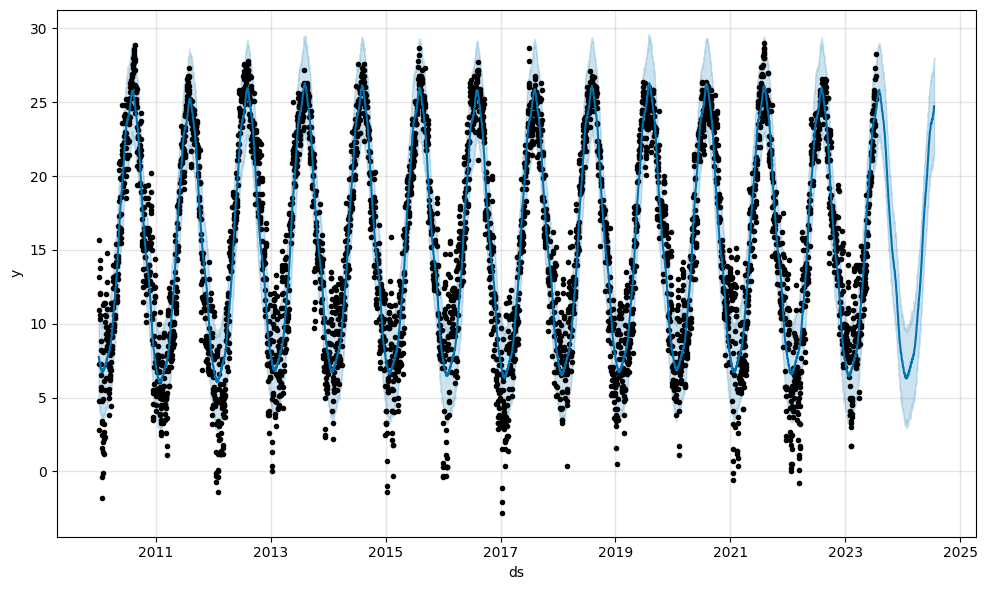

In [22]:
# Plot the forecasted data
plot1 = m.plot(forecast)

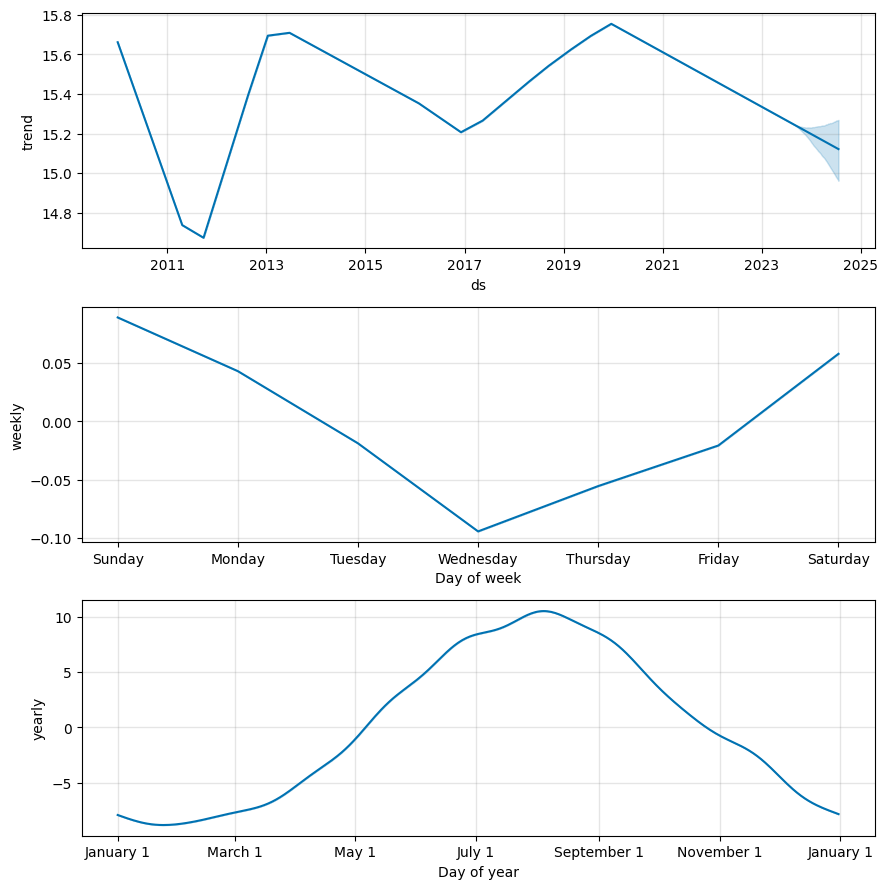

In [23]:
# Plot the components of the forecasted data
plt2 = m.plot_components(forecast)